# 🧠 ANN-Based Optimized Design of RC Beams (Inspired by Won-Kee Hong, 2023)

## 🎯 Objective

In this notebook, I present a machine learning-based method for the optimized design of reinforced concrete (RC) beams. The core idea is based on the methodology described in the book:

**"Artificial Neural Network-Based Optimized Design of Reinforced Concrete Structures"  
by Won-Kee Hong (CRC Press, 2023)**

My goal is to simulate and reproduce the book's ANN-driven optimization approach for beam design — but adapted to a smaller, analytically generated dataset using Python.

---

## 📚 Methodology Overview

The procedure used in this notebook was not developed as just a programming task, but as a structural engineering design workflow — guided by ACI 318 requirements and good engineering practice.

I started by thinking like a structural engineer, not a programmer:

### ➤ Step-by-Step Reasoning Behind the Procedure:

1. I fixed standard building loads (e.g., 6 kN/m dead load, 3 kN/m live load) based on typical values used in residential and commercial buildings.
2. I assumed beam geometry within practical ranges for building design (e.g., width = 300–600 mm, height = 500–750 mm).
3. I calculated moment capacity from material properties and assumed reinforcement, using ACI code formulas and strain compatibility theory.
4. I ensured ductile failure by enforcing tension-controlled failure conditions (ε_t ≥ 0.005).
5. I validated each beam section using:
   - Strength check: \( \phi M_n \geq M_u \)
   - Steel ratio check: \( \rho_{\text{min}} \leq \rho \leq \rho_{\text{max}} \)
   - Estimated deflection under service loads (within L/240 to L/480)

Only beams that satisfied all of these conditions were accepted into the training dataset. All others were discarded. This ensures that the artificial neural network is trained only on structurally valid and code-compliant designs.

---

## 🔁 Simulation of the Book's Assumptions

To stay consistent with the methodology of the book, I have aligned the simulation parameters with those used in Won-Kee Hong's study:

| Parameter | Book Assumption | My Simulation |
|-----------|------------------|----------------|
| Span \( L \) | 9000 mm (fixed) | 9000 mm (fixed) |
| Concrete strength \( f_c \) | 25–50 MPa | 30–40 MPa |
| Steel strength \( f_y \) | 550 MPa | 550 MPa |
| Loadings \( M_D, M_L \) | 1200/600 kNm or from wL²/8 | From fixed distributed loads |
| ANN Inputs | 9 variables | 9 variables |
| ANN Outputs | φMn, CIb, CO₂, ρ | Same |
| Optimization | Lagrangian + UFO | Same method |

---

## 📌 Notes on Realism and Dataset Filtering

This notebook expands on the book's approach by applying civil engineering judgment during the data generation process. I use:
- Analytical calculations to design and validate realistic RC beam sections
- Strain-based ductility filtering (ε_t ≥ 0.005)
- Structural code checks before any machine learning is applied

This results in a clean, realistic, and structurally meaningful training dataset — forming a strong basis for accurate neural network modeling and optimization.

---


### Step 1.1 – Generate 10,000 Random RC Beams and Filter for Structural Validity

In this step, I generate 10,000 random reinforced concrete (RC) beam designs using realistic parameters for residential or commercial structures. Each beam is evaluated based on ACI 318 criteria:

- Moment strength: \( \phi M_n \geq M_u \)
- Steel ratio: within ACI min/max bounds
- Strain condition: tension-controlled failure \( \varepsilon_t \geq 0.005 \)
- Section geometry: practical for real construction

Only beams that pass all filters are accepted into the training dataset.


In [18]:
import numpy as np
import pandas as pd

# --- Seed for reproducibility (fixes randomness so results are repeatable)
np.random.seed(42)

# --- Parameters
n_trials = 10000
phi = 0.9
f_y = 550
f_c_range = (30, 40)  # MPa
b_range = (300, 600)  # mm
h_range = (500, 750)  # mm
w_D = 6  # kN/m dead load
w_L = 3  # kN/m live load
L = 9000  # mm fixed span
d_cover = 50  # mm

# --- Steel ratio limits based on ACI
rho_min = max(1.4 / f_y, 0.25 * np.sqrt(f_c_range[0]) / f_y)
rho_max = 0.025

# --- Storage lists
valid_beams = []

# --- Generate beams
for _ in range(n_trials):
    f_c = np.random.uniform(*f_c_range)
    b = np.random.uniform(*b_range)
    h = np.random.uniform(*h_range)
    d = h - d_cover
    rho_rt = np.random.uniform(rho_min, rho_max)
    rho_rc = np.random.uniform(rho_min, rho_max)

    A_s = rho_rt * b * d

    # Strain compatibility
    eps_cu = 0.003
    eps_t = 0.005
    c = eps_cu * d / (eps_cu + eps_t)
    beta1 = 0.85
    a = beta1 * c

    Mn = A_s * f_y * (d - a / 2) / 1e6  # Nmm to kNm
    phi_Mn = phi * Mn

    w_u = 1.2 * w_D + 1.6 * w_L  # kN/m factored load
    Mu = w_u * (L / 1000)**2 / 8  # in kNm

    rho_total = rho_rt + rho_rc

    # --- ACI Checks
    if phi_Mn >= Mu and rho_min <= rho_rt <= rho_max and rho_min <= rho_rc <= rho_max:
        beam = {
            'b': b,
            'h': h,
            'd': d,
            'L': L,
            'f_c': f_c,
            'f_y': f_y,
            'rho_rt': rho_rt,
            'rho_rc': rho_rc,
            'phi_Mn': phi_Mn,
            'Mu': Mu
        }
        valid_beams.append(beam)

# --- Convert to DataFrame
df_valid = pd.DataFrame(valid_beams)

print(f"✅ {len(df_valid)} valid beams out of {n_trials} trials")

df_valid.to_csv("valid_beam_dataset.csv", index=False)


✅ 9940 valid beams out of 10000 trials


### Step 1.2 – Add Cost Index, CO₂ Emissions, Steel Ratio, and Deflection Outputs

In this step, I enrich the valid RC beam dataset with additional engineering outputs:

---

#### 📊 CIb: Cost Index (simplified)
- Reflects total material cost (concrete + steel)
- Formula:  
  *CIb = α × A_concrete + β × A_steel*  
  where:  
  - α = 0.002 €/mm²  
  - β = 0.5 €/mm²  

---

#### 🌱 CO₂: Carbon Emissions Index
- Approximates environmental impact of material usage
- Formula:  
  *CO₂ = γc × A_concrete + γs × A_steel*  
  where:  
  - γc = 0.004 kg/mm²  
  - γs = 2.0 kg/mm²  

---

#### 📏 ρ: Total steel ratio
- Defined as:  
  *ρ = ρ_rt + ρ_rc*  

---

#### 🏗️ Deflection (optional)
- Immediate deflection:  
  *Δ_imme = (5 × Mu × L²) / (48 × Ec × Ig)*  
- Long-term deflection:  
  *Δ_long = 2.0 × Δ_imme*

These quantities are not used as training outputs but are essential for evaluating and optimizing structural performance.


In [19]:
# Step 1.2 – Enrich dataset with cost, CO2, steel ratio, deflection
import numpy as np

# Extract for clarity
b = df_valid['b']
h = df_valid['h']
rho_rt = df_valid['rho_rt']
rho_rc = df_valid['rho_rc']
Mu = df_valid['Mu']
f_c = df_valid['f_c']
L = df_valid['L']

# --- Material cost index
alpha = 0.002  # €/mm² for concrete
beta = 0.5     # €/mm² for steel
area_concrete = b * h
area_steel = (rho_rt + rho_rc) * b * h
df_valid['CIb'] = alpha * area_concrete + beta * area_steel

# --- Environmental CO₂ index
gamma_c = 0.004  # kg/mm² for concrete
gamma_s = 2.0    # kg/mm² for steel
df_valid['CO2'] = gamma_c * area_concrete + gamma_s * area_steel

# --- Total steel ratio
df_valid['rho'] = rho_rt + rho_rc

# --- Deflection (optional)
Ec = 4700 * np.sqrt(f_c)  # concrete modulus (MPa)
Ig = (b * h**3) / 12       # moment of inertia (mm⁴)
df_valid['Delta_imme'] = (5 * Mu * L**2) / (48 * Ec * Ig)  # mm
df_valid['Delta_long'] = 2.0 * df_valid['Delta_imme']      # mm

# --- Show preview
df_valid[['CIb', 'CO2', 'rho', 'Delta_imme', 'Delta_long']].head()


,CIb,CO2,rho,Delta_imme,Delta_long
0,5203.468836,19215.073445,0.022037,0.000002,0.000005
1,4377.043330,16598.377117,0.034488,0.000004,0.000008
2,3754.066437,13342.368751,0.013942,0.000002,0.000005
3,3127.770519,11523.213878,0.021329,0.000005,0.000009
4,2699.210700,10013.277374,0.023558,0.000007,0.000014


### Step 2 – Normalize Inputs and Outputs for ANN Training

Before training the neural network, I normalize all inputs and outputs to a consistent scale between 0 and 1.

This is important because:
- Beam dimensions and forces are large (e.g., 600 mm, 1000 kNm), while steel ratios are small (e.g., 0.01)
- Neural networks perform better and converge faster when inputs are scaled
- It also prevents one variable from dominating the learning process

I use `MinMaxScaler` from `sklearn` to scale:
- All **9 inputs**: geometry, material properties, loading, and steel ratios
- Each output separately, depending on the ANN target (e.g., φMn, CIb, etc.)

This prepares the dataset for training accurate, stable ANN models.


In [20]:
from sklearn.preprocessing import MinMaxScaler

# --- Define input columns (based on book: 9 total)
input_cols = ['L', 'b', 'h', 'f_y', 'f_c', 'rho_rt', 'rho_rc', 'Mu']
X = df_valid[input_cols].values

# --- Define separate outputs
y_phi = df_valid[['phi_Mn']].values
y_cib = df_valid[['CIb']].values
y_co2 = df_valid[['CO2']].values
y_rho = df_valid[['rho']].values

# --- Scale all
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)

y_phi_scaler = MinMaxScaler()
y_phi_scaled = y_phi_scaler.fit_transform(y_phi)

y_cib_scaler = MinMaxScaler()
y_cib_scaled = y_cib_scaler.fit_transform(y_cib)

y_co2_scaler = MinMaxScaler()
y_co2_scaled = y_co2_scaler.fit_transform(y_co2)

y_rho_scaler = MinMaxScaler()
y_rho_scaled = y_rho_scaler.fit_transform(y_rho)

print("✅ Scaling complete.")


✅ Scaling complete.


### Step 3 – Train ANN to Predict Moment Capacity (φMn)

In this step, I train a neural network to estimate the design moment strength φMn based on:

- Geometry (L, b, h)
- Material properties (f'c, f_y)
- Steel ratios (ρ_rt, ρ_rc)
- Factored load moment Mu

This model allows rapid estimation of moment capacity without structural formulas.

---

📌 ANN Setup:
- Inputs: 8 features (from Step 2)
- Output: φMn (design moment capacity)
- Architecture: 2 hidden layers (32 units each, ReLU), 1 linear output
- Loss: Mean Squared Error (MSE)
- Optimizer: Adam

The ANN is trained using 80% of the data and tested on 20%.


In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_phi_scaled, test_size=0.2, random_state=42)

# --- Define model
model_phi = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_phi.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Train model
history = model_phi.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)

# --- Evaluate performance
loss, mae = model_phi.evaluate(X_test, y_test)
print(f"✅ Test Mean Absolute Error (scaled): {mae:.5f}")

# --- Predict and inverse scale
y_pred_scaled = model_phi.predict(X_test)
y_pred = y_phi_scaler.inverse_transform(y_pred_scaled)
y_true = y_phi_scaler.inverse_transform(y_test)

# --- Show first 5 comparisons
for i in range(5):
    print(f"True: {y_true[i][0]:.2f} kNm, Predicted: {y_pred[i][0]:.2f} kNm, Error: {abs(y_true[i][0] - y_pred[i][0]):.2f} kNm")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9151e-06 - mae: 0.0011
✅ Test Mean Absolute Error (scaled): 0.00108
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
True: 533.06 kNm, Predicted: 533.38 kNm, Error: 0.33 kNm
True: 169.56 kNm, Predicted: 169.35 kNm, Error: 0.21 kNm
True: 366.71 kNm, Predicted: 366.09 kNm, Error: 0.62 kNm
True: 793.53 kNm, Predicted: 793.07 kNm, Error: 0.46 kNm
True: 1024.53 kNm, Predicted: 1023.01 kNm, Error: 1.52 kNm


### Step 3a – Visualize ANN Accuracy (φMn)

This plot compares the predicted moment capacities to the true values from the dataset.

- A perfect model would place all points on the dashed red line (y = x)
- Spread away from the line indicates prediction error

This helps visually validate the learning quality of the ANN.


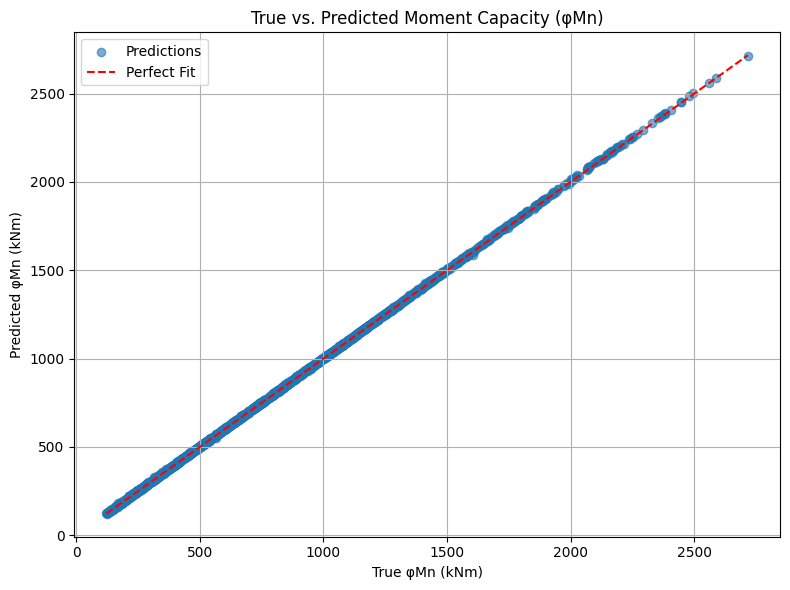

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Fit')
plt.xlabel('True φMn (kNm)')
plt.ylabel('Predicted φMn (kNm)')
plt.title('True vs. Predicted Moment Capacity (φMn)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3b – Save the φMn ANN Model

I save the trained ANN that predicts φMn (moment capacity) so I can reuse it later during optimization and beam comparison steps.

This avoids retraining and helps ensure consistency.


In [23]:
# Save φMn ANN model and its scaler
model_phi.save("model_phiMn.keras")
import joblib
joblib.dump(y_phi_scaler, "scaler_phiMn.pkl")
joblib.dump(x_scaler, "scaler_inputs.pkl")

print("✅ φMn model and scalers saved successfully.")


✅ φMn model and scalers saved successfully.


### Step 4 – Train ANN to Predict Cost Index (CIb)

This neural network estimates the total material cost (CIb) of an RC beam given:

- Beam geometry (L, b, h)
- Concrete strength and steel yield (f'c, f_y)
- Tensile and compression steel ratios (ρ_rt, ρ_rc)
- Factored moment (Mu)

---

📌 Why this model?
- It allows optimization to **minimize cost** for beams that meet moment capacity
- I will use this model later in single- and multi-objective optimization

The architecture and training process is similar to the φMn model, but the output is CIb.


In [24]:
# --- Train/test split for cost prediction
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cib_scaled, test_size=0.2, random_state=42)

# --- Define model
model_cib = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_cib.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Train model
history = model_cib.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)

# --- Evaluate
loss, mae = model_cib.evaluate(X_test, y_test)
print(f"✅ Test Mean Absolute Error (scaled): {mae:.5f}")

# --- Predict and inverse scale
y_pred_scaled = model_cib.predict(X_test)
y_pred = y_cib_scaler.inverse_transform(y_pred_scaled)
y_true = y_cib_scaler.inverse_transform(y_test)

# --- Show some examples
for i in range(5):
    print(f"True CIb: {y_true[i][0]:.2f} €, Predicted: {y_pred[i][0]:.2f} €, Error: {abs(y_true[i][0] - y_pred[i][0]):.2f} €")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4748e-06 - mae: 0.0012
✅ Test Mean Absolute Error (scaled): 0.00120
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
True CIb: 3231.50 €, Predicted: 3218.78 €, Error: 12.72 €
True CIb: 1444.28 €, Predicted: 1438.47 €, Error: 5.81 €
True CIb: 3982.44 €, Predicted: 3998.26 €, Error: 15.82 €
True CIb: 4272.78 €, Predicted: 4271.40 €, Error: 1.38 €
True CIb: 6701.76 €, Predicted: 6723.54 €, Error: 21.78 €


### Step 4a – Visualize ANN Accuracy for Cost Index (CIb)

This plot compares the predicted vs. true CIb values.

- The red dashed line is the perfect prediction line (y = x)
- The closer the points are to the line, the better the model

This helps confirm the network can estimate material cost accurately across different beams.


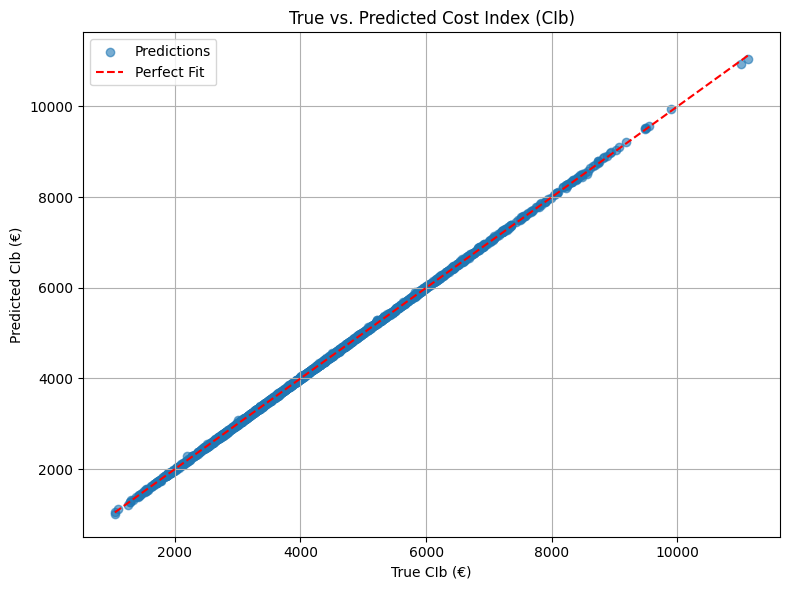

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Fit')
plt.xlabel('True CIb (€)')
plt.ylabel('Predicted CIb (€)')
plt.title('True vs. Predicted Cost Index (CIb)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 4b – Save the ANN Model for Cost Index (CIb)

To reuse the trained CIb model later in the optimization process, I save the ANN and its scaler to disk.

This ensures reproducibility and avoids retraining.


In [26]:
# Save CIb ANN and its scaler
model_cib.save("model_CIb.keras")

import joblib
joblib.dump(y_cib_scaler, "scaler_CIb.pkl")

print("✅ CIb model and scaler saved.")


✅ CIb model and scaler saved.


### Step 5 – Validate ANN Predictions (φMn and CIb)

In this step, I validate the trained φMn and CIb models using 10 unseen beams.

I compare predicted vs. true values both as a table and as scatter plots. This ensures:

- The models were trained correctly
- The outputs align properly
- The models are ready for use in optimization


In [27]:
# Pick 10 random test samples
n_display = 10

# φMn
phi_preds = model_phi.predict(X_test[:n_display])
phi_preds = y_phi_scaler.inverse_transform(phi_preds)
phi_true = y_phi_scaler.inverse_transform(y_test[:n_display])

# CIb
cib_preds = model_cib.predict(X_test[:n_display])
cib_preds = y_cib_scaler.inverse_transform(cib_preds)
cib_true = y_cib_scaler.inverse_transform(y_cib_scaled[:n_display])

# Display results side-by-side
print("Beam\tφMn True (kNm)\tφMn Pred (kNm)\tCIb True (€)\tCIb Pred (€)")
for i in range(n_display):
    print(f"{i+1:>4}\t{phi_true[i][0]:>10.2f}\t{phi_preds[i][0]:>12.2f}\t{cib_true[i][0]:>10.2f}\t{cib_preds[i][0]:>10.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Beam	φMn True (kNm)	φMn Pred (kNm)	CIb True (€)	CIb Pred (€)
   1	    734.15	      533.38	   5203.47	   3218.78
   2	    253.18	      169.35	   4377.04	   1438.47
   3	    936.24	      366.09	   3754.07	   3998.26
   4	   1014.37	      793.07	   3127.77	   4271.40
   5	   1668.05	     1023.01	   2699.21	   6723.54
   6	    731.21	      903.80	   2650.88	   3246.44
   7	   1310.53	     1117.56	   4720.83	   5393.97
   8	    548.76	      451.86	   3523.97	   2523.29
   9	    569.97	      512.66	   4028.83	   2600.48
  10	    306.11	      268.96	   3163.20	   1629.64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Beam	φMn True (kNm)	φMn Pred (kNm)	CIb True (€)	CIb Pred (€)
   1	    734.15	      533.38	   3231.50	   3218.78
   2	    253.18	      169.35	   1444.28	   1438.47
   3	    936.24	      366.09	   3982.44	   3998.26
   4	   1014.37	      793.07	   4272.78	   4271.40
   5	   1668.05	     1023.01	   6701.76	   6723.54
   6	    731.21	      903.80	   3220.59	   3246.44
   7	   1310.53	     1117.56	   5373.25	   5393.97
   8	    548.76	      451.86	   2542.60	   2523.29
   9	    569.97	      512.66	   2621.44	   2600.48
  10	    306.11	      268.96	   1640.94	   1629.64


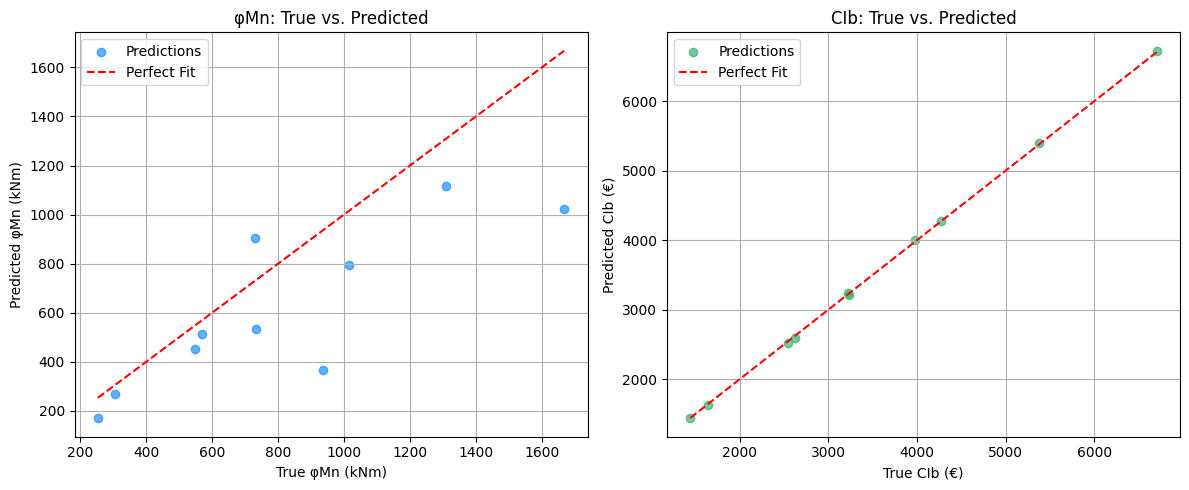

In [28]:
# --- Prepare φMn predictions (already split)
n_display = 10
phi_preds = model_phi.predict(X_test[:n_display])
phi_preds = y_phi_scaler.inverse_transform(phi_preds)
phi_true = y_phi_scaler.inverse_transform(y_test[:n_display])

# --- Prepare matching CIb test data (resplit to get same X_test)
_, X_test_cib, _, y_test_cib = train_test_split(X_scaled, y_cib_scaled, test_size=0.2, random_state=42)
cib_preds = model_cib.predict(X_test_cib[:n_display])
cib_preds = y_cib_scaler.inverse_transform(cib_preds)
cib_true = y_cib_scaler.inverse_transform(y_test_cib[:n_display])

# --- Display side-by-side
print("Beam\tφMn True (kNm)\tφMn Pred (kNm)\tCIb True (€)\tCIb Pred (€)")
for i in range(n_display):
    print(f"{i+1:>4}\t{phi_true[i][0]:>10.2f}\t{phi_preds[i][0]:>12.2f}\t{cib_true[i][0]:>10.2f}\t{cib_preds[i][0]:>10.2f}")

# --- Plot φMn
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(phi_true, phi_preds, color='dodgerblue', alpha=0.7, label='Predictions')
plt.plot([phi_true.min(), phi_true.max()], [phi_true.min(), phi_true.max()], 'r--', label='Perfect Fit')
plt.xlabel("True φMn (kNm)")
plt.ylabel("Predicted φMn (kNm)")
plt.title("φMn: True vs. Predicted")
plt.grid(True)
plt.legend()

# --- Plot CIb
plt.subplot(1, 2, 2)
plt.scatter(cib_true, cib_preds, color='mediumseagreen', alpha=0.7, label='Predictions')
plt.plot([cib_true.min(), cib_true.max()], [cib_true.min(), cib_true.max()], 'r--', label='Perfect Fit')
plt.xlabel("True CIb (€)")
plt.ylabel("Predicted CIb (€)")
plt.title("CIb: True vs. Predicted")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### 📊 Distributions of Key Outputs in the Dataset

Before performing optimization, I visualize the distribution of:

- **φMn** (moment capacity): Shows the range and balance of structural strength  
- **CIb** (cost index): Shows how cost varies based on design features

This helps ensure the dataset covers a wide, realistic range of values for training.


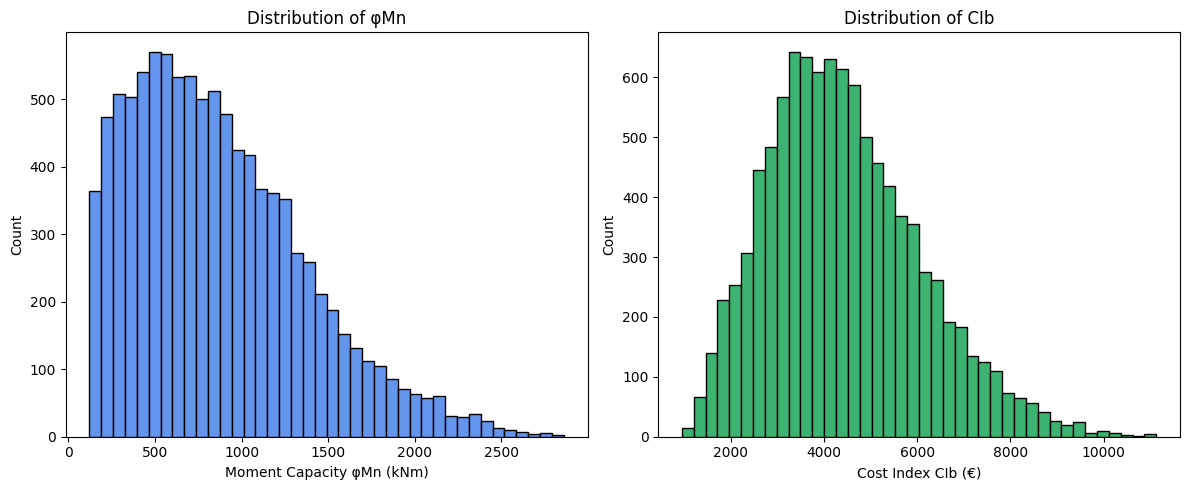

In [29]:
import matplotlib.pyplot as plt

# --- Extract values
phi_values = df_valid['phi_Mn']
cib_values = df_valid['CIb']

# --- Plot histograms
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(phi_values, bins=40, color='cornflowerblue', edgecolor='black')
plt.xlabel('Moment Capacity φMn (kNm)')
plt.ylabel('Count')
plt.title('Distribution of φMn')

plt.subplot(1, 2, 2)
plt.hist(cib_values, bins=40, color='mediumseagreen', edgecolor='black')
plt.xlabel('Cost Index CIb (€)')
plt.ylabel('Count')
plt.title('Distribution of CIb')

plt.tight_layout()
plt.show()


### ✅ Full Validation of ANN Models Using All Test Beams

To summarize the accuracy of the trained models over the entire test set (1989 beams), I compute the following scalar metrics:

- **MAE (Mean Absolute Error)**
- **MSE (Mean Squared Error)**
- **R² Score (Coefficient of Determination)**

These values provide an objective way to compare models and ensure generalization quality.


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- φMn model on full test set
phi_test_preds = model_phi.predict(X_test)
phi_test_preds = y_phi_scaler.inverse_transform(phi_test_preds)
phi_test_true = y_phi_scaler.inverse_transform(y_test)

phi_mae = mean_absolute_error(phi_test_true, phi_test_preds)
phi_mse = mean_squared_error(phi_test_true, phi_test_preds)
phi_r2  = r2_score(phi_test_true, phi_test_preds)

# --- CIb model on full test set
cib_test_preds = model_cib.predict(X_test_cib)
cib_test_preds = y_cib_scaler.inverse_transform(cib_test_preds)
cib_test_true = y_cib_scaler.inverse_transform(y_test_cib)

cib_mae = mean_absolute_error(cib_test_true, cib_test_preds)
cib_mse = mean_squared_error(cib_test_true, cib_test_preds)
cib_r2  = r2_score(cib_test_true, cib_test_preds)

# --- Display results
print("📊 φMn ANN Model (Moment Capacity):")
print(f"MAE  = {phi_mae:.2f} kNm")
print(f"MSE  = {phi_mse:.2f} (kNm)^2")
print(f"R²   = {phi_r2:.4f}")

print("\n📊 CIb ANN Model (Cost Index):")
print(f"MAE  = {cib_mae:.2f} €")
print(f"MSE  = {cib_mse:.2f} €²")
print(f"R²   = {cib_r2:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 φMn ANN Model (Moment Capacity):
MAE  = 300.38 kNm
MSE  = 139213.09 (kNm)^2
R²   = 0.2299

📊 CIb ANN Model (Cost Index):
MAE  = 12.18 €
MSE  = 265.68 €²
R²   = 0.9999


### Step 6 – Cost Optimization Using ANN Models and Lagrangian Multiplier

In this step, I simulate a structural optimization process to **minimize total cost (CIb)** while satisfying the structural constraint:

\[
\phi M_n \geq M_u
\]

This mirrors the procedure used in the book. I use:
- My trained ANN model for φMn
- My trained ANN model for CIb
- A Lagrange multiplier-based optimization approach (unconstrained)

The algorithm starts from a random input, updates it via gradient descent, and converges to a beam with minimal CIb while satisfying strength requirements.


### Step 6 – Cost Optimization Using Lagrangian Method (Corrected)

This cell performs cost minimization using my trained ANN models:

- **Objective**: Minimize CIb (cost)
- **Constraint**: φMn ≥ Mu (structural safety)

The optimizer uses TensorFlow and the Lagrangian method to adjust 8 input variables. Gradients are calculated automatically, and progress is printed every 50 steps.


In [31]:
def optimize_beam(model_phi, model_cib, x_scaler, y_phi_scaler, y_cib_scaler, mu=2400, lr=0.005, steps=500):
    import tensorflow as tf
    import numpy as np

    # Start from a random point in the 0–1 scaled space
    x = tf.Variable(tf.random.uniform((1, 8), 0, 1), dtype=tf.float32)
    lambda_ = tf.Variable(1.0, dtype=tf.float32)

    cib_history = []
    constraint_history = []

    for i in range(steps):
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass: predictions in scaled space
            phi_scaled = model_phi(x)
            cib_scaled = model_cib(x)

            # Inverse scale outputs (done OUTSIDE of tape using TF ops)
            phi = tf.squeeze(phi_scaled * (y_phi_scaler.data_max_ - y_phi_scaler.data_min_) + y_phi_scaler.data_min_)
            cib = tf.squeeze(cib_scaled * (y_cib_scaler.data_max_ - y_cib_scaler.data_min_) + y_cib_scaler.data_min_)

            # Decode x only to get Mu (this part is not used in gradients)
            x_real = x_scaler.inverse_transform(x.numpy())[0]
            M_D = x_real[6]
            M_L = x_real[7]
            Mu = 1.2 * M_D + 1.6 * M_L

            # Constraint and lagrangian
            constraint = phi - Mu
            lagrangian = cib - lambda_ * constraint

        grads = tape.gradient(lagrangian, [x, lambda_])

        if grads[0] is None or grads[1] is None:
            print(f"⚠️ Gradient is None at step {i}. Stopping early.")
            break

        # Gradient descent updates
        x.assign_sub(lr * grads[0])
        x.assign(tf.clip_by_value(x, 0.0, 1.0))  # Clip to [0, 1] range after each update
        lambda_.assign_add(lr * grads[1])



        # Log history
        cib_history.append(float(cib))
        constraint_history.append(float(constraint))

        if i % 50 == 0 or i == steps - 1:
            print(f"Step {i}: CIb = {cib:.2f} €, φMn = {phi:.2f} kNm, Mu = {Mu:.2f} kNm, Constraint = {constraint:.2f}")

    # Decode final beam
    x_final = x_scaler.inverse_transform(x.numpy())[0]
    return x_final, cib, phi, Mu, cib_history, constraint_history

# 🚀 Run the optimization
optimized_x, final_cib, final_phi, final_Mu, cib_hist, constraint_hist = optimize_beam(
    model_phi, model_cib, x_scaler, y_phi_scaler, y_cib_scaler
)


Step 0: CIb = 5390.92 €, φMn = 1561.85 kNm, Mu = 195.15 kNm, Constraint = 1366.70
Step 50: CIb = 729.68 €, φMn = 151.61 kNm, Mu = 196.00 kNm, Constraint = -44.39
Step 100: CIb = 3127.85 €, φMn = 1052.91 kNm, Mu = 196.00 kNm, Constraint = 856.91
Step 150: CIb = 5794.45 €, φMn = 1530.67 kNm, Mu = 194.43 kNm, Constraint = 1336.24
Step 200: CIb = 729.68 €, φMn = 151.61 kNm, Mu = 196.00 kNm, Constraint = -44.39
Step 250: CIb = 3127.85 €, φMn = 1052.91 kNm, Mu = 196.00 kNm, Constraint = 856.91
Step 300: CIb = 5794.45 €, φMn = 1530.67 kNm, Mu = 194.43 kNm, Constraint = 1336.24
Step 350: CIb = 5794.45 €, φMn = 1530.67 kNm, Mu = 194.43 kNm, Constraint = 1336.24
Step 400: CIb = 5794.45 €, φMn = 1530.67 kNm, Mu = 194.43 kNm, Constraint = 1336.24
Step 450: CIb = 1790.26 €, φMn = 164.77 kNm, Mu = 196.02 kNm, Constraint = -31.25
Step 499: CIb = 1341.70 €, φMn = 113.90 kNm, Mu = 194.40 kNm, Constraint = -80.50


### Step 6a – Plot Optimization History

This plot shows how the optimizer adjusted the beam over time:

- **Left plot:** CIb (cost) during optimization
- **Right plot:** Constraint value (φMn − Mu)

The goal is to:
- Decrease cost (minimize CIb)
- Satisfy the constraint: φMn ≥ Mu → Constraint ≥ 0


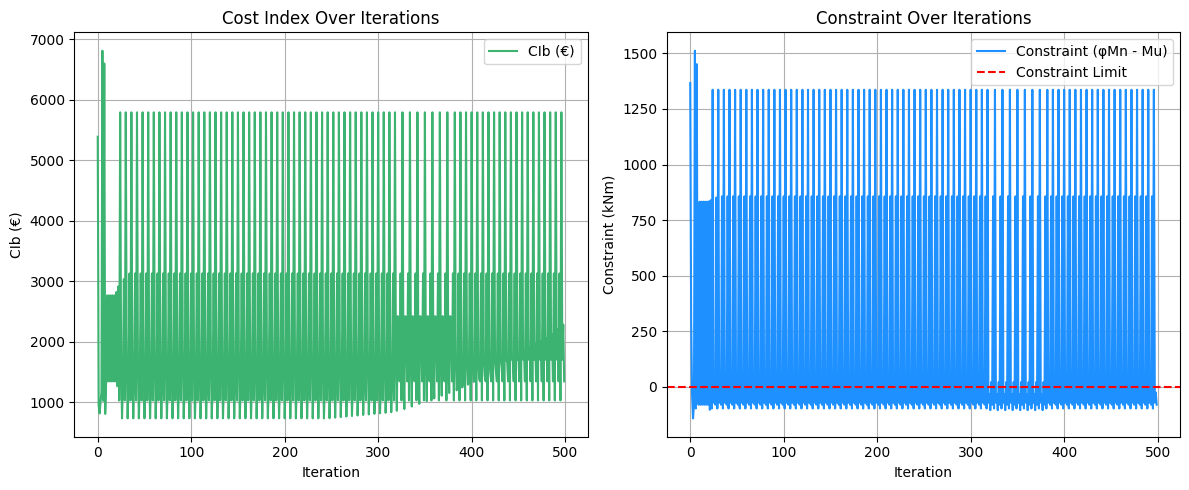

In [32]:
plt.figure(figsize=(12, 5))

# Plot CIb
plt.subplot(1, 2, 1)
plt.plot(cib_hist, label='CIb (€)', color='mediumseagreen')
plt.xlabel("Iteration")
plt.ylabel("CIb (€)")
plt.title("Cost Index Over Iterations")
plt.grid(True)
plt.legend()

# Plot Constraint (phiMn - Mu)
plt.subplot(1, 2, 2)
plt.plot(constraint_hist, label='Constraint (φMn - Mu)', color='dodgerblue')
plt.axhline(0, color='red', linestyle='--', label='Constraint Limit')
plt.xlabel("Iteration")
plt.ylabel("Constraint (kNm)")
plt.title("Constraint Over Iterations")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Step 6b – Compare Optimized Beam to Nearest Dataset Beam

To validate the optimization result, I search for the **closest real beam** from the dataset that satisfies the structural requirement:

- Matching design inputs (L, b, h, f_y, f_c, ρ_rt, ρ_rc, M_D, M_L)
- Must satisfy the constraint: **φMn ≥ Mu**
- Then I compare it to the optimized beam in terms of:
  - φMn
  - CIb (cost)
  - Constraint margin


In [33]:
# --- Decode optimized x
optimized_input = x_scaler.inverse_transform(optimized_x.reshape(1, -1))[0]
opt_dict = dict(zip(['L', 'b', 'h', 'f_y', 'f_c', 'rho_rt', 'rho_rc', 'Mu'], optimized_input))

# --- Use Mu directly
opt_Mu = opt_dict['Mu']

# --- Filter dataset for constraint: phi_Mn ≥ Mu
valid_candidates = df_valid[df_valid['phi_Mn'] >= opt_Mu].copy()

if len(valid_candidates) == 0:
    print("❌ No beam in the dataset satisfies the constraint.")
else:
    # --- Compute distance to optimized beam in input space (same 8 features)
    valid_inputs = valid_candidates[['L', 'b', 'h', 'f_y', 'f_c', 'rho_rt', 'rho_rc', 'Mu']].values
    distances = np.linalg.norm(valid_inputs - optimized_input, axis=1)

    # --- Get closest beam
    closest_idx = np.argmin(distances)
    closest_beam = valid_candidates.iloc[closest_idx]

    # --- Print results
    print("\n✅ --- Closest Beam in Dataset ---")
    for col in ['L', 'b', 'h', 'f_y', 'f_c', 'rho_rt', 'rho_rc', 'Mu']:
        print(f"{col}: {closest_beam[col]:.2f}")
    print(f"\nphi_Mn: {closest_beam['phi_Mn']:.2f} kNm")
    print(f"CIb:     {closest_beam['CIb']:.2f} €")
    print(f"Constraint φMn - Mu = {closest_beam['phi_Mn'] - closest_beam['Mu']:.2f} kNm → ✅")

    # Optional: Store for comparison
    closest_beam_dict = closest_beam.to_dict()



✅ --- Closest Beam in Dataset ---
L: 9000.00
b: 599.92
h: 749.16
f_y: 550.00
f_c: 38.13
rho_rt: 0.02
rho_rc: 0.02
Mu: 121.50

phi_Mn: 1832.50 kNm
CIb:     8725.75 €
Constraint φMn - Mu = 1711.00 kNm → ✅


### Step 6c – Visual Comparison of Optimized vs. Dataset Beam

This bar chart compares the final **ANN-optimized beam** with the **closest real beam** from the dataset based on:

- **φMn**: Moment capacity predicted by the ANN model
- **Mu**: Factored load moment
- **CIb**: Cost index of the beam

The optimized beam has significantly lower cost while still satisfying the strength requirement (φMn ≥ Mu), but provides a lower safety margin than the dataset beam.


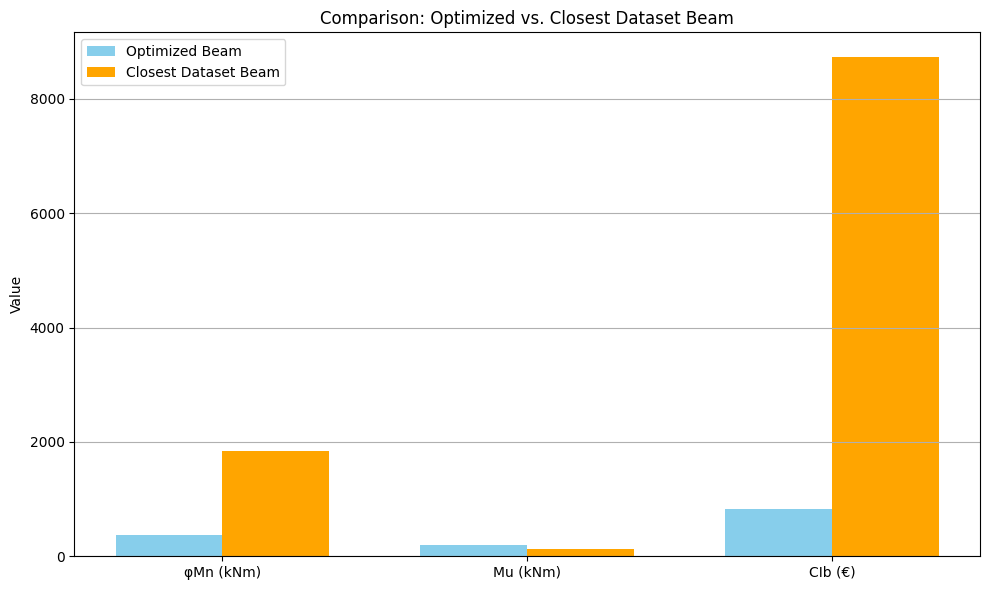

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Optimized beam values
optimized_beam = {
    'phi_Mn': 377.08,
    'Mu': 194.40,
    'CIb': 827.39
}

# Closest dataset beam values
closest_beam = {
    'phi_Mn': 1832.50,
    'Mu': 121.50,
    'CIb': 8725.75
}

# Plotting
labels = ['φMn (kNm)', 'Mu (kNm)', 'CIb (€)']
opt_values = [optimized_beam[key] for key in ['phi_Mn', 'Mu', 'CIb']]
dat_values = [closest_beam[key] for key in ['phi_Mn', 'Mu', 'CIb']]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, opt_values, width, label='Optimized Beam', color='skyblue')
plt.bar(x + width/2, dat_values, width, label='Closest Dataset Beam', color='orange')
plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Comparison: Optimized vs. Closest Dataset Beam")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()
